In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
sequence_length = 4 # length of my input sentence ex: my name is sowmya
batch_size = 1
input_dim = 512 # vector dimension of every word that goes into the attension unit
d_model = 512 # output of the attension unit for every single word

x = torch.randn( (batch_size, sequence_length, input_dim))

In [3]:
x.size()

torch.Size([1, 4, 512])

In [4]:
qkv_layer = nn.Linear(input_dim, 3 * d_model)

In [5]:
qkv = qkv_layer(x)

In [6]:
qkv.shape

torch.Size([1, 4, 1536])

Text(0.5, 1.0, 'qkv distribution')

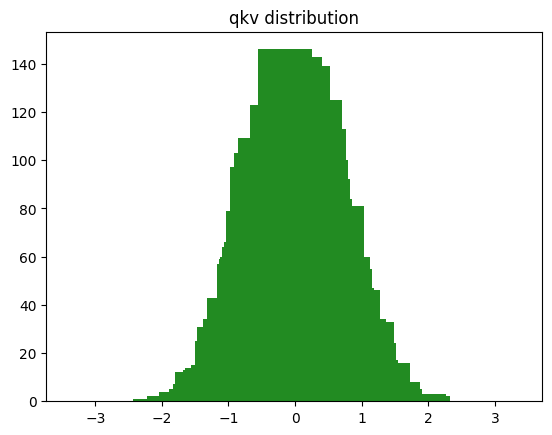

In [7]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1, 1, 0.01) * 3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title('qkv distribution')

In [8]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3 * head_dim)

In [9]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [10]:
qkv = qkv.permute(0, 2, 1, 3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [11]:
q, k, v = qkv.chunk(3, dim=-1)
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

In [15]:
import math

d_k = q.shape[-1]
scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
scaled.shape

torch.Size([1, 8, 4, 4])

In [51]:
k.transpose(-2, -1).shape

torch.Size([1, 8, 64, 4])

In [16]:
k.T.shape

torch.Size([64, 4, 8, 1])

In [21]:
y = torch.randn(2, 3)
print(y)
torch.transpose(y, 0, 1)

tensor([[ 0.3834,  2.1839,  0.0034],
        [-0.0996,  0.4425, -0.8474]])


tensor([[ 0.3834, -0.0996],
        [ 2.1839,  0.4425],
        [ 0.0034, -0.8474]])

In [22]:
torch.transpose(y, 1, 0)

tensor([[ 0.3834, -0.0996],
        [ 2.1839,  0.4425],
        [ 0.0034, -0.8474]])

In [26]:
mask = torch.full(scaled.size(), float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1]

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [27]:
(scaled + mask) [0][0]

tensor([[ 0.0141,    -inf,    -inf,    -inf],
        [-0.1033,  0.1646,    -inf,    -inf],
        [ 0.3030, -0.1783, -0.2972,    -inf],
        [ 0.4042,  0.1497, -0.6351, -0.2128]], grad_fn=<SelectBackward0>)

In [28]:
scaled += mask

In [29]:
np.exp(-0.1033) / (np.exp(-0.1033) + np.exp(0.0404))

0.46413669261922225

In [30]:
attention = F.softmax(scaled, dim=-1)

In [31]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.4334, 0.5666, 0.0000, 0.0000],
        [0.4615, 0.2852, 0.2532, 0.0000],
        [0.3747, 0.2905, 0.1325, 0.2022]], grad_fn=<SelectBackward0>)

In [32]:
values = torch.matmul(attention, v)
values.shape

torch.Size([1, 8, 4, 64])

In [35]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.shape[-1]
    scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask 
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [36]:
values, attention = scaled_dot_product(q, k, v, mask=None)

In [37]:
attention.shape

torch.Size([1, 8, 4, 4])

In [38]:
attention[0][0]

tensor([[0.2601, 0.2174, 0.3103, 0.2122],
        [0.2417, 0.3159, 0.1766, 0.2658],
        [0.3470, 0.2144, 0.1904, 0.2482],
        [0.3747, 0.2905, 0.1325, 0.2022]], grad_fn=<SelectBackward0>)

In [39]:
values.size()

torch.Size([1, 8, 4, 64])

In [40]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.size()

torch.Size([1, 4, 512])

In [41]:
linear_layer = nn.Linear(d_model, d_model)

In [42]:
out = linear_layer(values)

In [43]:
out.shape

torch.Size([1, 4, 512])

In [44]:
out

tensor([[[ 0.1081,  0.1132, -0.0566,  ...,  0.4524, -0.0071,  0.1241],
         [-0.0007, -0.0715,  0.1969,  ...,  0.1052, -0.1459, -0.0287],
         [-0.3710,  0.2072, -0.0917,  ...,  0.0089,  0.0486, -0.1326],
         [-0.0686,  0.2063, -0.0115,  ..., -0.1247, -0.0897, -0.0870]]],
       grad_fn=<ViewBackward0>)

# class

In [48]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    scaled = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scaled += mask 
    attention = F.softmax(scaled, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention


class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, d_model, num_heads):
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model 
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim, 3 * d_model)
        self.linear_layer = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.size()
        print(f"x.size(): {x.size()}")
        qkv = self.qkv_layer(x)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3 * self.head_dim)
        print(f"qkv.size(): {qkv.size()}")
        qkv = qkv.permute(0, 2, 1, 3)
        print(f"qkv.size(): {qkv.size()}")
        q, k, v = qkv.chunk(3, dim=-1)
        print(f"q size(): {q.size()}, k size(): {k.size()}, v size(): {v.size()}")
        values, attention = scaled_dot_product(q, k, v, mask)
        print(f"values.size(): {values.size()}, attention.size(): {attention.size()}")
        values = values.reshape(batch_size, sequence_length, self.num_heads*self.head_dim)
        print(f"values.size(): {values.size()}")
        out = self.linear_layer(values)
        print(f"out.size(): {out.size()}")
        return out

Input

In [53]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn( (batch_size, sequence_length, input_dim) )

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model.forward(x)

x.size(): torch.Size([30, 5, 1024])
qkv.size(): torch.Size([30, 5, 1536])
qkv.size(): torch.Size([30, 5, 8, 192])
qkv.size(): torch.Size([30, 8, 5, 192])
q size(): torch.Size([30, 8, 5, 64]), k size(): torch.Size([30, 8, 5, 64]), v size(): torch.Size([30, 8, 5, 64])
values.size(): torch.Size([30, 8, 5, 64]), attention.size(): torch.Size([30, 8, 5, 5])
values.size(): torch.Size([30, 5, 512])
out.size(): torch.Size([30, 5, 512])
